# Linear Algebra, Accuracy, and Confidence Intervals

### IMPORTS

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.api import OLS
%matplotlib inline

### Dataset

In [2]:
df = pd.read_csv("data/cleaned_mtcars.csv")
df.head()

,name,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [3]:
%%capture --no-stdout --no-display
# Jupyter magic to silence pandas concat `FutureWarning` caused
# by statsmodels internals for add_constant. The assumption
# is that statsmodels will fix add_constant in a future release
# to conform to pandas requirements and prevent errors.

y = df[["mpg"]].values
X = df[["cyl","disp","hp","wt","qsec"]]

X = sm.add_constant(X)

<hr style="height:2pt">

## Linear Algebra, Accuracy, and Confidence Intervals

You will see how *uncertainty* in the $\beta$ coefficients can directly impact our ability to make predictions with a linear regression model and how in general we can do inference on the predictors. 

### First a little review...

The linear model assumes:

$$ y_i \sim N(\beta_0+\beta_1 x_i,\sigma^2 )   $$

This means, pun intended, that $ \mu_{y_i} = \beta_0+\beta_1 x_i $, which can be estimated with $ \hat{\mu}_{y_i} = \hat{\beta}_0+\hat{\beta}_1 x_i $.

And for a new observation not in the data set, once we measure the new predictor value, $x^*$, we can predict its response, $y^*$, from our model as:

$$\hat{y}^* = \hat{\mu}_{y_i} + \hat{\varepsilon}^* $$

Which can be calculated by using the estimate for $\hat{\mu}_{y_i}$ and adding on a randomly selected value for $\hat{\varepsilon}^*$ from its assumed (and estimated) distribution, $N(0,\hat{\sigma}^2)$.


## Question 1

Fit a simple linear regression model to predict `mpg` with `disp` using [OLS](https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html) from `statsmodels.api` which will calculate confidence intervals (and other useful statistics) for you. Call your model `simple_model` and fit on the entire dataset.

Be aware that (1) unlike sklearn's LinearRegression, statsmodels does **not** add an intercept by default and (2) the expected order of arguments to `fit()` is flipped: $y$ first, then $X$. You can use `sm.add_constant()` to add the ones column (we did this for you above). As always, be sure to consult the [documentation](https://www.statsmodels.org/dev/index.html).

In [4]:
x_var = "disp"

# Fit a simple linear regression predicting mpg via weight
simple_model = sm.OLS(y, X[["const",x_var]]).fit()
simple_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     76.51
Date:                Thu, 05 Oct 2023   Prob (F-statistic):           9.38e-10
Time:                        13:50:29   Log-Likelihood:                -82.105
No. Observations:                  32   AIC:                             168.2
Df Residuals:                      30   BIC:                             171.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.5999      1.230     24.070      0.000      27.088      32.111
disp          -0.0412      0.005     -8.747      0.000      -0.051      -0.032
==============================================================================
Omnibus:                        3.368   Durbin-Watson:                   1.250
Prob(Omnibus):                  0.186   Jarque-Bera (JB):                3.049
Skew:                           0.719   Prob(JB):                        0.218
Kurtosis:                       2.532   Cond. No.                         558.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Once you've fit the model you can can call `simple_model.get_prediction().summary_frame()` to access the confidence intervals for our true mean predictions at various values of `disp` and make a well-labeled plot showing:

 1. The observed values of `disp` and `mpg`.
 2. The estimated regression line.
 3. The upper and lower bounds of the 95% confidence interval for the true average (not the observed) `mpg` at any given displacement.


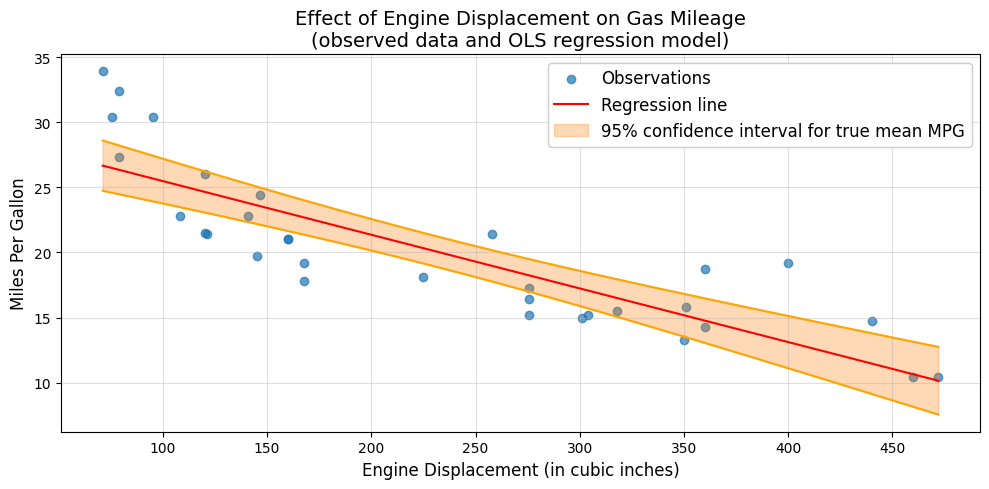

In [5]:
# Generate continuous array of predictions for plotting curve
x_vals = np.linspace(X[x_var].min(), X[x_var].max(), 500)
line_y_vals = simple_model.predict(sm.add_constant(x_vals))

# Generate summary_frame for OLS model predictions
prediction_int = simple_model.get_prediction(
    sm.add_constant(x_vals)
).summary_frame()

# Generate plot as required
plt.figure(figsize=(10, 5))
plt.scatter(X[x_var], y, alpha=0.7, label="Observations")
plt.plot(
    x_vals,
    line_y_vals,
    c="r",
    label="Regression line",
)
plt.plot(
    x_vals,
    prediction_int["mean_ci_upper"],
    c="orange",
)
plt.plot(
    x_vals,
    prediction_int["mean_ci_lower"],
    c="orange",
    label="",
)
plt.fill_between(
    x_vals,
    prediction_int["mean_ci_lower"],
    prediction_int["mean_ci_upper"],
    color="tab:orange",
    alpha=.3,
    label="95% confidence interval for true mean MPG",
)
plt.xlabel("Engine Displacement (in cubic inches)", fontsize=12)
plt.ylabel("Miles Per Gallon", fontsize=12)
plt.title(
    "Effect of Engine Displacement on Gas Mileage\n"
    "(observed data and OLS regression model)",
    fontsize=14,
)
plt.grid(":", alpha=0.4)
plt.legend(loc=1, framealpha=1, fontsize=12)
plt.tight_layout()


Why do we have a confidence interval for our true mean prediction values?  Why isn't the mean prediction just a single number?

The regression line predicts mean `mpg` (miles per gallon) at each `disp` (engine displacement) value. For instance, we think the average miles per gallon of all cars with an engine displacement of 250 cubic inches will be 20 miles per gallon. However, we don't perfectly know what the average miles per gallon is at each engine displacement value, and if we re-collected the data and re-ran our model our prediction might be higher or lower. The bounds above give a reasonable estimate of where the true average miles per gallon might be.

In [6]:
# Generate prediction summary for disp=400
disp_val = 400

summary = simple_model.get_prediction([1, disp_val]).summary_frame()

# Print summary information for interpretation of results
print(
    "MPG prediction summary for a vehicle with a "
    f"{disp_val} cubic inch engine displacement:\n"
)
for col in summary.columns:
    print(f"\t{col:<18}{summary[col][0]:.4f}")


MPG prediction summary for a vehicle with a 400 cubic inch engine displacement:

	mean              13.1138
	mean_se           0.9831
	mean_ci_lower     11.1060
	mean_ci_upper     15.1216
	obs_ci_lower      6.1765
	obs_ci_upper      20.0511


1. Our best single estimate is that the car will get 13.11 miles per gallon.
2. However, we are not completely certain in that value. Based on the data, the optimal prediction could reasonably be anywhere between 11.1 and 15.12 miles per gallon.
3. The range of **_actual_** miles per gallon ratings we see could reasonably be as low as 6.17 or as high as 20.05. The range quoted above (i.e. 11.1 to 15.12) is only describing what we think, with 95% confidence, the **_average_** miles per gallon of cars with an engine displacement of 400 cubic inches might be.

Create 100 bootstrap samples in order to create 100 bootstrapped regression models and store their estimated intercept and slope values. Use these bootstrapped estimates to build the 95% confidence intervals, and recreate the plot from that question with your new bootstrapped confidence intervals. 

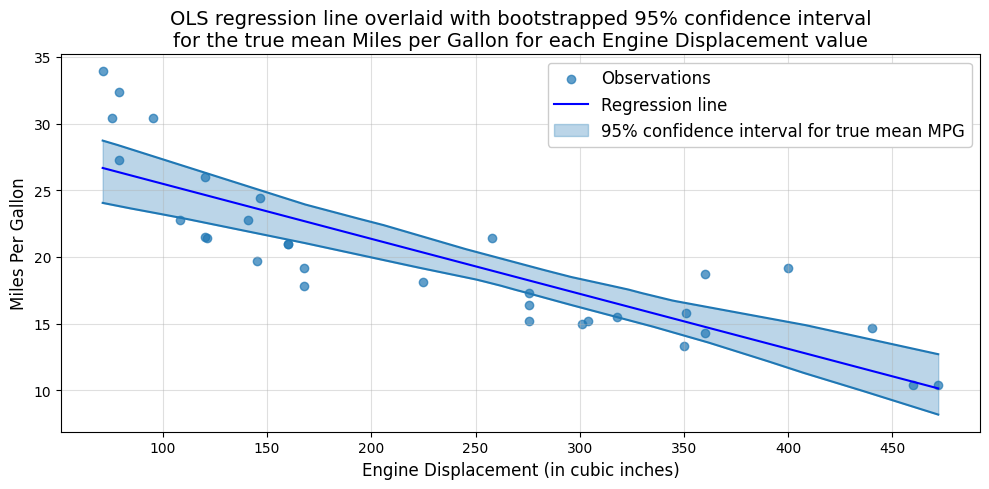

In [7]:
# Set parameters for bootstrapped predictions
samples = 100
alpha = 0.05

# Create empty arrays for storing bootstrap results
num_data_points = len(y)
intercepts = np.zeros(samples)
slopes = np.zeros(samples)

# Generate bootstrapped predictions
for i in range(samples):
    df_bootstrapped = df.sample(n=num_data_points, replace=True)
    y_boostrapped = df_bootstrapped[["mpg"]].values
    x_bootstrapped = sm.add_constant(df_bootstrapped[["disp"]].values)
    FittedOLS = sm.OLS(y_boostrapped, x_bootstrapped).fit()
    intercepts[i] = FittedOLS.params[0]
    slopes[i] = FittedOLS.params[1]

# Calculate and store lower and upper bounds
# Managing array shapes can be a little tricky for calculating
# means using numpy vectorized operations rather than inefficiently
# looping through each observation in our dataset. Here, we
# reshape intercepts and x_vals to accomplish this.
means = intercepts.reshape(1, -1) + slopes * x_vals.reshape(-1,1)
lower_bound_bootsrap = np.quantile(means, alpha / 2, axis=1)
upper_bound_bootsrap = np.quantile(means, 1 - (alpha / 2), axis=1)

# Note that instead of explicitly setting fontsize arguments
# throughout our plot code, we could instead modify matplotlib's
# rcParams as such. Just be certain to call rcdefaults() after
# plotting to restore the defaults for later plots.
# font = {"weight" : "bold", "size"   : 12}
# matplotlib.rc("font", **font)

plt.figure(figsize=(10, 5))
plt.scatter(
    X[x_var],
    y,
    alpha=0.7,
    label="Observations",
)
plt.plot(
    x_vals,
    line_y_vals,
    c="blue",
    label="Regression line",
)
plt.plot(
    x_vals,
    lower_bound_bootsrap,
    c="tab:blue",
)
plt.plot(x_vals, upper_bound_bootsrap, c="tab:blue")
plt.fill_between(
    x_vals,
    lower_bound_bootsrap,
    upper_bound_bootsrap,
    color="tab:blue",
    alpha=0.3,
    label="95% confidence interval for true mean MPG",
)
plt.legend(loc=1, framealpha=1, fontsize=12)
plt.xlabel("Engine Displacement (in cubic inches)", fontsize=12)
plt.ylabel("Miles Per Gallon", fontsize=12)
plt.title(
    "OLS regression line overlaid with bootstrapped 95% "
    "confidence interval\nfor the true mean Miles per Gallon "
    "for each Engine Displacement value",
    fontsize=14,
)
plt.grid(":", alpha=0.4)
plt.tight_layout()


The intervals based on the two approaches should be reasonably similar in width and both get wider as you estimate $\mu_y$ at an $x$ further from $\bar{x}$. However, the intervals calculated via bootstrapping will not be as smooth since there will be random noise in the estimated bounds.

Another interval of uncertainty in a regression model is called a *prediction interval*.  A prediction interval gives a range of plausible values for a future individual observation, $\hat{y}^*$, given a specific value of $x$ in general (`disp` here).  How should the 95% prediction interval calculated at a `disp` value of 400 compare to the corresponding 95% confidence interval for the mean predicted `mpg`?  


The 95% prediction interval (PI) will be centered at the same place as the 95% confidence interval (centered at the regression line), but will generally be much wider.  These PIs should contain roughly 95% of current and future data points.  The mathematical justification is:


$$E(\hat{y}^*) = E(\hat{\mu}_{y}^* + \varepsilon) = E(\hat{\mu}_{y}^*)+0$$


$$Var(\hat{y}^*) = Var(\hat{\mu}_{y^*} + \varepsilon) = Var(\hat{\mu}_{y}^*) + Var(\varepsilon) = Var(\hat{\mu}_{y^*}) + \sigma^2$$